# Load Data and Word-Embedding Models

In [1]:
import os
import re
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('NER_train.json', 'r'))
val_data = json.load(open('NER_val.json', 'r'))
test_data = json.load(open('NER_test.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [2]:
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('ones')
        return torch.ones(size)

# GRU Implementation

In [3]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.gru = nn.GRU(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.gru(x, h0)
        out = self.fc(out)
        return out


# Training and Validation Code

In [4]:
def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cuda', epochs=10):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            #  Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                text = data["text"]
                pattern = r'[ ]+'
                text = re.split(pattern, text)
                labels = data["labels"]
                #  Convert text to embeddings
                embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model(embedded_text)
                # Compute loss
                loss = criterion(outputs.view(-1, output_size), targets)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1
        

# Fine-Tuning on Validation Data

In [5]:
def fine_tune(model, embedding_model, val_data,  criterion, optimizer, device='cuda', epochs=3):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    model = model.to(device)
    model.train()
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        tuning_loss = 0
        actual = []
        predicted = []
        for _, data in val_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            actual.extend(targets.tolist())     
            tuning_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        tuning_loss = tuning_loss / len(val_data)
        accuracy = accuracy_score(actual, predicted)
        f1 = f1_score(actual, predicted, average="macro")
        print(f"FineTuning: Loss: {tuning_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        

# Testing Code

In [6]:
def test(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
    
    if show_labelwise:
        labelwise_predictions = {}
        for label in label_mapping:
            labelwise_predictions[label_mapping[label]] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            labelwise_predictions[test_actual[i]]["actual"].append(test_actual[i])
            labelwise_predictions[test_actual[i]]["predicted"].append(test_predicted[i])
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        print('Labelwise F1 Scores:')
        print(labelwise_f1)
        print('Labelwise Accuracy Scores:')
        print(labelwise_accuracy)
        if plot:
            import matplotlib.pyplot as plt
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
    return accuracy, f1

In [7]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [43]:
input_size = 300  # Embedding size
hidden_size = 128  # 128 Hidden size of the RNN
output_size = 27   # BIO encoding

# For Word2Vec Embeddings

In [44]:
gru_word2vec_model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_word2vec_model.parameters(), lr=0.001)
# optimizer = optim.SGD(gru_word2vec_model.parameters(), lr=0.1)   #momentum=0.9, 0.6, 0.1, 0.0

In [45]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            gru_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10


Training: Loss: 0.4086, Accuracy: 0.8980, F1: 0.3701
Validation: Loss: 0.3217, Accuracy: 0.9140, F1: 0.4420
Epoch 2/10
Training: Loss: 0.2837, Accuracy: 0.9213, F1: 0.5322
Validation: Loss: 0.2979, Accuracy: 0.9199, F1: 0.5136
Epoch 3/10
Training: Loss: 0.2455, Accuracy: 0.9297, F1: 0.5966
Validation: Loss: 0.2956, Accuracy: 0.9218, F1: 0.5485
Epoch 4/10
Training: Loss: 0.2177, Accuracy: 0.9364, F1: 0.6384
Validation: Loss: 0.2963, Accuracy: 0.9206, F1: 0.5503
Epoch 5/10
Training: Loss: 0.1931, Accuracy: 0.9426, F1: 0.6745
Validation: Loss: 0.3042, Accuracy: 0.9212, F1: 0.5603
Epoch 6/10
Training: Loss: 0.1728, Accuracy: 0.9481, F1: 0.7056
Validation: Loss: 0.3186, Accuracy: 0.9193, F1: 0.5526
Epoch 7/10
Training: Loss: 0.1564, Accuracy: 0.9526, F1: 0.7362
Validation: Loss: 0.3335, Accuracy: 0.9190, F1: 0.5520
Epoch 8/10
Training: Loss: 0.1415, Accuracy: 0.9567, F1: 0.7580
Validation: Loss: 0.3543, Accuracy: 0.9189, F1: 0.5530
Epoch 9/10
Training: Loss: 0.1313, Accuracy: 0.9590, F1: 0.

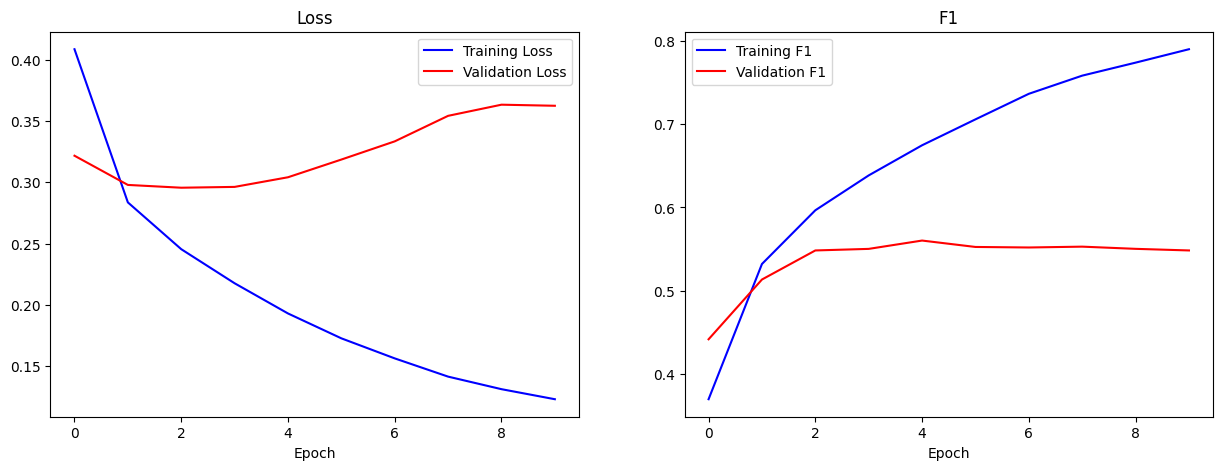

In [46]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [47]:
# fine_tune(gru_word2vec_model, word2vec, val_data, criterion, optimizer, device='cuda', epochs=2)

In [48]:
gru_word2vec_model = gru_word2vec_model.to('cpu')
torch.save(gru_word2vec_model, "t1_model3_word2vec.pt")

In [49]:
test_accuracy, test_f1 = test("t1_model3_word2vec.pt", word2vec, test_data, device='cuda', show_labelwise=True, plot=False)
print(("GRU with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.036581003328772996, 1: 0.05164066702528241, 2: 0.07661375661375662, 3: 0.03507152745731426, 4: 0.04083120670798395, 5: 0.05582329317269077, 6: 0.054982817869415807, 7: 0.1, 8: 0.10623123123123124, 9: 0.22611464968152864, 10: 0.14366319444444445, 11: 0.12578616352201258, 12: 0.09838556505223171, 13: 0.09166666666666666, 14: 0.04446914952751529, 15: 0.04700028636884307, 16: 0.1459915611814346, 17: 0.07272727272727272, 18: 0.19444444444444445, 19: 0.07236842105263157, 20: 0.03885714285714286, 21: 0.24999999999999997, 22: 0.0909090909090909, 23: 0.09195402298850575, 24: 0.13333333333333333, 25: 0.0, 26: 0.06912442396313365}
Labelwise Accuracy Scores:
{0: 0.975673707210488, 1: 0.39669421487603307, 2: 0.5261627906976745, 3: 0.2389937106918239, 4: 0.36129032258064514, 5: 0.5036231884057971, 6: 0.49230769230769234, 7: 0.6666666666666666, 8: 0.7389033942558747, 9: 0.8255813953488372, 10: 0.7574370709382151, 11: 0.7865168539325843, 12: 0.7944785276073619, 13: 0.3793103

# For GloVe Embeddings

In [50]:
input_size, hidden_size, output_size = 300, 64, 27

gru_glove_model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_glove_model.parameters(), lr=0.001)
optimizer = optim.SGD(gru_glove_model.parameters(), lr=0.1)   #momentum=0.9, 0.6, 0.1, 0.0

In [51]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            gru_glove_model, glove, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.5521, Accuracy: 0.8678, F1: 0.1780
Validation: Loss: 0.4825, Accuracy: 0.8773, F1: 0.2710
Epoch 2/10
Training: Loss: 0.4521, Accuracy: 0.8850, F1: 0.2900
Validation: Loss: 0.4521, Accuracy: 0.8837, F1: 0.3342
Epoch 3/10
Training: Loss: 0.4257, Accuracy: 0.8902, F1: 0.3406
Validation: Loss: 0.4390, Accuracy: 0.8862, F1: 0.3590
Epoch 4/10
Training: Loss: 0.4102, Accuracy: 0.8931, F1: 0.3676
Validation: Loss: 0.4360, Accuracy: 0.8855, F1: 0.3765
Epoch 5/10
Training: Loss: 0.3970, Accuracy: 0.8956, F1: 0.3865
Validation: Loss: 0.4325, Accuracy: 0.8864, F1: 0.3870
Epoch 6/10
Training: Loss: 0.3853, Accuracy: 0.8980, F1: 0.4001
Validation: Loss: 0.4320, Accuracy: 0.8874, F1: 0.4022
Epoch 7/10
Training: Loss: 0.3748, Accuracy: 0.9003, F1: 0.4151
Validation: Loss: 0.4340, Accuracy: 0.8884, F1: 0.4094
Epoch 8/10
Training: Loss: 0.3651, Accuracy: 0.9026, F1: 0.4283
Validation: Loss: 0.4370, Accuracy: 0.8869, F1: 0.4092
Epoch 9/10
Training: Loss: 0.3559, Accuracy: 0.9

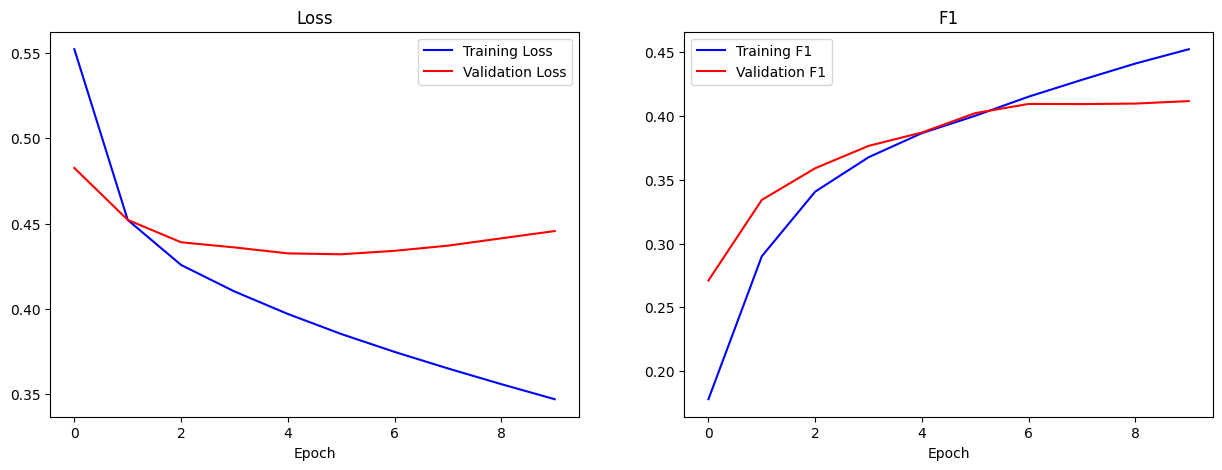

In [52]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [53]:
# fine_tune(gru_glove_model, glove, val_data, criterion, optimizer, device='cuda', epochs=2)

In [54]:
test_accuracy, test_f1 = test(gru_glove_model, glove, test_data, device='cuda', show_labelwise=True, plot=False)
print(("GRU with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.03768637789256346, 1: 0.03451676528599606, 2: 0.05602161239869189, 3: 0.0016563146997929609, 4: 0.018018018018018014, 5: 0.024778761061946906, 6: 0.04232199027738061, 7: 0.08631772268135904, 8: 0.06800618238021638, 9: 0.0657065706570657, 10: 0.0767277856135402, 11: 0.03733766233766234, 12: 0.06255716114871045, 13: 0.0358974358974359, 14: 0.05063291139240507, 15: 0.04077723043240285, 16: 0.11194029850746268, 17: 0.039999999999999994, 18: 0.03333333333333334, 19: 0.11578947368421051, 20: 0.03629976580796253, 21: 0.0, 22: 0.0909090909090909, 23: 0.22282608695652176, 24: 0.0, 25: 0.05, 26: 0.005208333333333334}
Labelwise Accuracy Scores:
{0: 0.9604879825200291, 1: 0.2892561983471074, 2: 0.5726744186046512, 3: 0.012578616352201259, 4: 0.1935483870967742, 5: 0.22826086956521738, 6: 0.37948717948717947, 7: 0.6351351351351351, 8: 0.6892950391644909, 9: 0.5658914728682171, 10: 0.6224256292906178, 11: 0.25842696629213485, 12: 0.5245398773006135, 13: 0.1206896551724138,

In [55]:
gru_glove_model = gru_glove_model.to('cpu')
torch.save(gru_glove_model, "t1_model3_glove.pt")

In [56]:
test_accuracy, test_f1 = test("t1_model3_glove.pt", glove, test_data, device='cuda', show_labelwise=True, plot=False)
print(("GRU with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.03768637789256346, 1: 0.03451676528599606, 2: 0.05602161239869189, 3: 0.0016563146997929609, 4: 0.018018018018018014, 5: 0.024778761061946906, 6: 0.04232199027738061, 7: 0.08631772268135904, 8: 0.06800618238021638, 9: 0.0657065706570657, 10: 0.0767277856135402, 11: 0.03733766233766234, 12: 0.06255716114871045, 13: 0.0358974358974359, 14: 0.05063291139240507, 15: 0.04077723043240285, 16: 0.11194029850746268, 17: 0.039999999999999994, 18: 0.03333333333333334, 19: 0.11578947368421051, 20: 0.03629976580796253, 21: 0.0, 22: 0.0909090909090909, 23: 0.22282608695652176, 24: 0.0, 25: 0.05, 26: 0.005208333333333334}
Labelwise Accuracy Scores:
{0: 0.9604879825200291, 1: 0.2892561983471074, 2: 0.5726744186046512, 3: 0.012578616352201259, 4: 0.1935483870967742, 5: 0.22826086956521738, 6: 0.37948717948717947, 7: 0.6351351351351351, 8: 0.6892950391644909, 9: 0.5658914728682171, 10: 0.6224256292906178, 11: 0.25842696629213485, 12: 0.5245398773006135, 13: 0.1206896551724138,

# For FastText Embeddings

In [57]:
input_size, hidden_size, output_size = 300, 128, 27
gru_fasttext_model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_fasttext_model.parameters(), lr=0.001)
# optimizer = optim.SGD(gru_fasttext_model.parameters(), lr=0.1)   #momentum=0.9, 0.6, 0.1, 0.0

In [58]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        gru_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.4378, Accuracy: 0.8938, F1: 0.3321
Validation: Loss: 0.3142, Accuracy: 0.9154, F1: 0.4177
Epoch 2/10
Training: Loss: 0.2835, Accuracy: 0.9220, F1: 0.4719
Validation: Loss: 0.2814, Accuracy: 0.9226, F1: 0.4839
Epoch 3/10
Training: Loss: 0.2435, Accuracy: 0.9309, F1: 0.5521
Validation: Loss: 0.2696, Accuracy: 0.9249, F1: 0.5187
Epoch 4/10
Training: Loss: 0.2165, Accuracy: 0.9378, F1: 0.6059
Validation: Loss: 0.2621, Accuracy: 0.9284, F1: 0.5480
Epoch 5/10
Training: Loss: 0.1941, Accuracy: 0.9435, F1: 0.6470
Validation: Loss: 0.2607, Accuracy: 0.9302, F1: 0.5554
Epoch 6/10
Training: Loss: 0.1744, Accuracy: 0.9484, F1: 0.6810
Validation: Loss: 0.2691, Accuracy: 0.9292, F1: 0.5582
Epoch 7/10
Training: Loss: 0.1590, Accuracy: 0.9525, F1: 0.7118
Validation: Loss: 0.2725, Accuracy: 0.9301, F1: 0.5634
Epoch 8/10
Training: Loss: 0.1443, Accuracy: 0.9567, F1: 0.7343
Validation: Loss: 0.2778, Accuracy: 0.9293, F1: 0.5709
Epoch 9/10
Training: Loss: 0.1322, Accuracy: 0.9

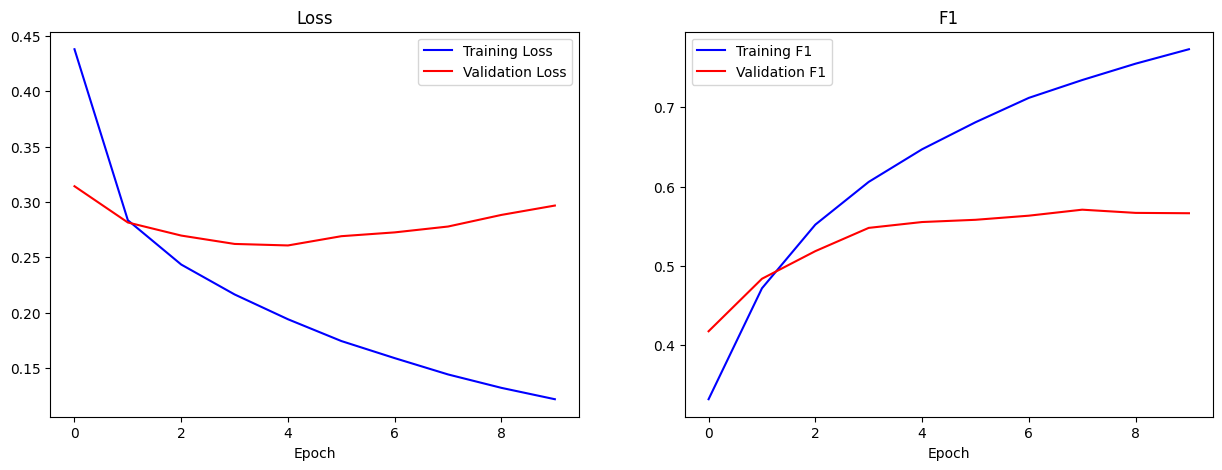

In [59]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [60]:
# fine_tune(gru_fasttext_model, fasttext, val_data, criterion, optimizer, device='cuda', epochs=2)

In [61]:
test_accuracy, test_f1 = test(gru_fasttext_model, fasttext, test_data, device='cuda', show_labelwise=True, plot=False)
print(("GRU with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.03814948588985815, 1: 0.04662698412698413, 2: 0.07801418439716312, 3: 0.03203014601978333, 4: 0.041892379920548936, 5: 0.05002821139740455, 6: 0.05382343288480473, 7: 0.07000755477209772, 8: 0.09287402904424182, 9: 0.18319327731092436, 10: 0.15147732001664585, 11: 0.09584664536741214, 12: 0.0953492897450866, 13: 0.0759493670886076, 14: 0.04743935309973046, 15: 0.05519176800748363, 16: 0.22992700729927007, 17: 0.1, 18: 0.125, 19: 0.07236842105263157, 20: 0.04909560723514212, 21: 0.08333333333333334, 22: 0.0909090909090909, 23: 0.3049645390070922, 24: 0.25641025641025644, 25: 0.11111111111111112, 26: 0.07222222222222223}
Labelwise Accuracy Scores:
{0: 0.983903860160233, 1: 0.3884297520661157, 2: 0.6395348837209303, 3: 0.2138364779874214, 4: 0.3741935483870968, 5: 0.48188405797101447, 6: 0.4205128205128205, 7: 0.6261261261261262, 8: 0.7180156657963447, 9: 0.8449612403100775, 10: 0.8329519450800915, 11: 0.7584269662921348, 12: 0.7515337423312883, 13: 0.3620689655

In [62]:
gru_fasttext_model = gru_fasttext_model.to('cpu')
torch.save(gru_fasttext_model, "t1_model3_fasttext.pt")

In [63]:
test_accuracy, test_f1 = test("t1_model3_fasttext.pt", fasttext, test_data, device='cuda', show_labelwise=True, plot=False)
print(("GRU with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.03814948588985815, 1: 0.04662698412698413, 2: 0.07801418439716312, 3: 0.03203014601978333, 4: 0.041892379920548936, 5: 0.05002821139740455, 6: 0.05382343288480473, 7: 0.07000755477209772, 8: 0.09287402904424182, 9: 0.18319327731092436, 10: 0.15147732001664585, 11: 0.09584664536741214, 12: 0.0953492897450866, 13: 0.0759493670886076, 14: 0.04743935309973046, 15: 0.05519176800748363, 16: 0.22992700729927007, 17: 0.1, 18: 0.125, 19: 0.07236842105263157, 20: 0.04909560723514212, 21: 0.08333333333333334, 22: 0.0909090909090909, 23: 0.3049645390070922, 24: 0.25641025641025644, 25: 0.11111111111111112, 26: 0.07222222222222223}
Labelwise Accuracy Scores:
{0: 0.983903860160233, 1: 0.3884297520661157, 2: 0.6395348837209303, 3: 0.2138364779874214, 4: 0.3741935483870968, 5: 0.48188405797101447, 6: 0.4205128205128205, 7: 0.6261261261261262, 8: 0.7180156657963447, 9: 0.8449612403100775, 10: 0.8329519450800915, 11: 0.7584269662921348, 12: 0.7515337423312883, 13: 0.3620689655